In [6]:
import numpy as np
from pcd_helper import *
import torch
import os
from network.BEV_Unet import BEV_Unet
from network.ptBEV import ptBEVnet
from dataloader.dataset import SemKITTI_label_name
import yaml
import open3d as o3d

from pytorch_grad_cam import GradCAM
import cv2
from PIL import Image
import matplotlib.pyplot as plt

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Load Data

In [7]:
scene = "08"
file = "000000"

# Path to the Velodyne .bin file and .label file
bin_file_path = f'data/sequences/{scene}/velodyne/{file}.bin'
label_file = f"data/sequences/{scene}/labels/{file}.label"
label_output_path = f"out/predicted_labels/{scene}/{file}.npy"

In [8]:
# Read the point cloud data
points = read_velodyne_bin(bin_file_path)

# Extract x, y, z coordinates (first three columns)
xyz = points[:, :3]

# Load labels
labels = load_labels(label_file)
true_colors = label2color(labels)

# Predicted labels
predicted_grid_labels = np.load(label_output_path)
predicted_colors = grid_label2color(xyz, predicted_grid_labels)

with open('semantic-kitti.yaml', 'r') as stream:
    semkittiyaml = yaml.safe_load(stream)

In [14]:
predicted_grid_labels.shape
val_grid = get_grid_ind(cart2polar(xyz))

pred = predicted_grid_labels[val_grid[:,0],val_grid[:,1],val_grid[:,2]]

pred.shape

(123389,)

# Build Model

In [17]:
# Model parameters
pytorch_device = torch.device('cpu')
unique_label = np.asarray(sorted(list(SemKITTI_label_name.keys())))[1:] - 1
grid_size = [480, 360, 32]
compression_model = grid_size[2]
circular_padding = True
fea_dim = 9
model_save_path = 'pretrained_weight/SemKITTI_PolarSeg.pt'

# Build model
my_BEV_model=BEV_Unet(n_class=len(unique_label), n_height=compression_model, input_batch_norm=True, dropout=0.5, circular_padding=circular_padding)
my_model = ptBEVnet(my_BEV_model, pt_model='pointnet', grid_size=grid_size, fea_dim=fea_dim, max_pt_per_encode=256,
                        out_pt_fea_dim=512, kernal_size=1, pt_selection='random', fea_compre=compression_model, explain=True)

if os.path.exists(model_save_path):
    my_model.load_state_dict(torch.load(model_save_path, map_location=torch.device('cpu')))  # Run on CPU

my_model.to(pytorch_device)
my_BEV_model.to(pytorch_device)
my_model.eval()
my_BEV_model.eval()
''

''

# Make prediction

In [19]:
# Load input features
pt_fea = np.load(f"out/predicted_labels/{scene}/{file}_features.npy")  # contains: centered data on each voxel (3), polar coord (3), xyz (2), reflection value (1)
val_pt_fea_ten = [torch.from_numpy(i).type(torch.FloatTensor).to(pytorch_device) for i in pt_fea]

val_grid = [get_grid_ind(cart2polar(xyz))]
val_grid_ten = [torch.from_numpy(i[:,:2]).to(pytorch_device) for i in val_grid]

# Run a forward pass
input_tensor = my_model(val_pt_fea_ten, val_grid_ten)
output = my_BEV_model(input_tensor)

print(output.shape)

torch.Size([1, 19, 480, 360, 32])


# Perform GRAD CAM

In [20]:
target = "road"

normalized_masks = torch.nn.functional.softmax(output, dim=1).cpu()

sem_class_to_idx = {semkittiyaml['labels'][v]: k-1 for k,v in semkittiyaml['learning_map_inv'].items()}

target_category = sem_class_to_idx[target]
target_mask = normalized_masks[0, :, :, :].argmax(axis=0).detach().cpu().numpy()
target_mask_float = np.float32(target_mask == target_category)

target_mask_float.shape

(480, 360, 32)

In [21]:
colormap = cv2.COLORMAP_JET

target_layers = [my_BEV_model.network.dropout]
targets = [SemanticSegmentationTarget(target_category, target_mask_float)]

with GradCAM(model=my_BEV_model, target_layers=target_layers) as cam:
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]


In [33]:
# Heatmap from grayscale image
heatmap = cv2.applyColorMap(np.uint8(255 * grayscale_cam), colormap)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
heatmap = np.float32(heatmap) / 255

cam = heatmap / np.max(heatmap)
cam_image = np.uint8(255 * cam)

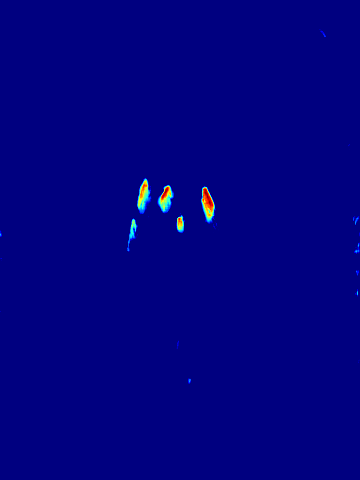

In [17]:
# Visualize importances as image

image = Image.fromarray(cam_image)
#image.save(f'{target}_image.png')
image

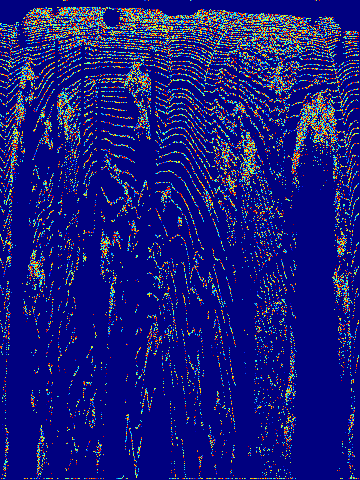

In [18]:
# Visualize input as image

x = input_tensor.squeeze(0)  # Now the shape is [32, 480, 360]

grayscale_tensor = x.mean(dim=0)  # Now the shape is [480, 360]
grayscale_image = grayscale_tensor.unsqueeze(-1)  # Now the shape is [480, 360, 1]

grayscale_image_np = grayscale_image.detach().numpy()

heatmap = cv2.applyColorMap(np.uint8(255 * grayscale_image_np), colormap)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
heatmap = np.float32(heatmap) / 255

image_original = heatmap / np.max(heatmap)
image_original = np.uint8(255 * image_original)

Image.fromarray(image_original)

# Result: heatmap on point cloud

In [34]:
# Visualize heatmap

# Create Open3D PointCloud object
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(xyz)
# pcd.colors = o3d.utility.Vector3dVector(true_colors)

# Add colors
heatmap_colors = cam_image[val_grid[0][:,0],val_grid[0][:,1],:]/255
pcd.colors = o3d.utility.Vector3dVector(heatmap_colors)

# Visualize the point cloud
o3d.visualization.draw_geometries([pcd], window_name="GRAD-CAM Point Cloud", width=800, height=600)


In [2]:
import numpy as np
best_mask_tp = np.array([])

best_mask_tp.sum()

0.0

In [1]:
from explain import *

xai = ExplainTarget()
out = xai.find_objects()

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
out['000085']["fn"][0]

{'cluster_mask': array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, Fals

In [2]:
import numpy as np

array = np.array([1, 1, 2, 1, 2, 2, 3, 3, 4, 4, 4, 4])
unique_elements, counts = np.unique(array, return_counts=True)

print("Unique elements:", unique_elements)
print("Counts:", counts)

Unique elements: [1 2 3 4]
Counts: [3 3 2 4]
